## **IMPORT LIBRARY**

In [22]:
# Preprocessing Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Model Imports
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

## **DATASET**

**Model matematis *plant***:

$$
y(k)= \frac{1}{[1+y(k-1)]^2} + 0,25x(k) - 0,3x(k-1)
$$
</br></nr>
**Info database**:</br>
x(t) = generate random -1 s.d. 1</br>
y(t) = model plant
</br></br>
**Dimensi data**:</br>
30000 $\times$ 2

**(1). BUAT DATASET**

In [2]:
def plant_data(N):
    # buat nilai x
    np.random.seed(42)
    x_val = np.random.uniform(-1, 1, N)

    # buat nilai y
    y_val = np.zeros(N)
    y_val[0] = 0.0

    for k in range(1, N):
        y_val[k] = 1/(1 + y_val[k-1]**2) + 0.25*x_val[k] - 0.3*x_val[k-1]

    dataset = pd.DataFrame({'x': x_val, 'y': y_val})
    return dataset

# Jumlah data
N = 30004

dk = plant_data(N)
dk

,x,y
0,-0.250920,0.000000
1,0.901429,1.300633
2,0.463988,0.217088
3,0.197317,0.865127
4,-0.687963,0.340751
...,...,...
29999,-0.485204,0.424156
30000,0.276289,1.062157
30001,-0.081415,0.366645
30002,0.928997,1.138175


**(2). BUAT MODEL DATA**

In [3]:
def lagged_dataset(df, cols, lag):
    df_new = pd.DataFrame()
    for col in cols:
        for i in range(lag+1):
            if i == 0:
                new_col_name = f'{col}(t)'
            else:
                new_col_name = f'{col}(t-{i})'

            # geser nilai kolom ke bawah sebanyak i
            df_new[new_col_name] = df[col].shift(i)
    
    # drop baris dengan nilai NaN
    df_new = df_new.dropna().reset_index(drop=True)

    return df_new

df_lag = lagged_dataset(dk, cols=['x', 'y'], lag=4)
df_lag

,x(t),x(t-1),x(t-2),x(t-3),x(t-4),y(t),y(t-1),y(t-2),y(t-3),y(t-4)
0,-0.687963,0.197317,0.463988,0.901429,-0.250920,0.340751,0.865127,0.217088,1.300633,0.000000
1,-0.688011,-0.687963,0.197317,0.463988,0.901429,0.930354,0.340751,0.865127,0.217088,1.300633
2,-0.883833,-0.688011,-0.687963,0.197317,0.463988,0.521478,0.930354,0.340751,0.865127,0.217088
3,0.732352,-0.883833,-0.688011,-0.687963,0.197317,1.234439,0.521478,0.930354,0.340751,0.865127
4,0.202230,0.732352,-0.883833,-0.688011,-0.687963,0.227073,1.234439,0.521478,0.930354,0.340751
...,...,...,...,...,...,...,...,...,...,...
29995,-0.485204,-0.197990,-0.961088,0.495648,0.904551,0.424156,1.028279,0.516434,0.323239,1.060438
29996,0.276289,-0.485204,-0.197990,-0.961088,0.495648,1.062157,0.424156,1.028279,0.516434,0.323239
29997,-0.081415,0.276289,-0.485204,-0.197990,-0.961088,0.366645,1.062157,0.424156,1.028279,0.516434
29998,0.928997,-0.081415,0.276289,-0.485204,-0.197990,1.138175,0.366645,1.062157,0.424156,1.028279


## **EDA**

**(1). STRUKTUR DATA**

In [4]:
print("Info Dataset")
print("Ukuran dataset lag:", df_lag.shape, "\n")
df_lag.info()

Info Dataset
Ukuran dataset lag: (30000, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x(t)    30000 non-null  float64
 1   x(t-1)  30000 non-null  float64
 2   x(t-2)  30000 non-null  float64
 3   x(t-3)  30000 non-null  float64
 4   x(t-4)  30000 non-null  float64
 5   y(t)    30000 non-null  float64
 6   y(t-1)  30000 non-null  float64
 7   y(t-2)  30000 non-null  float64
 8   y(t-3)  30000 non-null  float64
 9   y(t-4)  30000 non-null  float64
dtypes: float64(10)
memory usage: 2.3 MB


**(2). CEK MISSING VALUES**

In [5]:
df_lag.isna().sum()

,0
x(t),0
x(t-1),0
x(t-2),0
x(t-3),0
x(t-4),0
y(t),0
y(t-1),0
y(t-2),0
y(t-3),0
y(t-4),0


**(3). CEK DUPLIKASI**

In [6]:
df_lag.duplicated().sum()

np.int64(0)

## **PRE-PROCESSING DATA**

**(1). SPLIT DATA INPUT DAN TARGET**

In [7]:
X = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)', 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)']].values
Y = df_lag[['y(t)']].values

print("Input (X) set shape :", X.shape)
print("Target (Y) set shape:", Y.shape)

Input (X) set shape : (30000, 9)
Target (Y) set shape: (30000, 1)


**(2). SPLIT MODEL DATASET**

X = [X(t), X(t-1), X(t-2), X(t-3), X(t-4), Y(t-1), Y(t-2), Y(t-3), Y(t-4)]</br>
Y = [Y(t)]</br>

**Training** : 15000 dataset</br>
**Validasi** : 10000 (5000 data training akhir + 5000 dataset)</br>
**Testing**  : 10000 dataset

In [8]:
def split_dataset(X, Y):
    assert len(X) == len(Y), "Panjang X dan Y harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    X_train = X[:15000]
    Y_train = Y[:15000]

    X_val = np.concatenate([X_train[-5000:], X[15000:20000]])
    Y_val = np.concatenate([Y_train[-5000:], Y[15000:20000]])

    X_test = X[20000:]
    Y_test = Y[20000:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)

print("Train shape  :", X_train.shape, Y_train.shape)
print("Val shape    :", X_val.shape, Y_val.shape)
print("Test shape   :", X_test.shape, Y_test.shape)

Train shape  : (15000, 9) (15000, 1)
Val shape    : (10000, 9) (10000, 1)
Test shape   : (10000, 9) (10000, 1)


**Visualisasi Dataset**

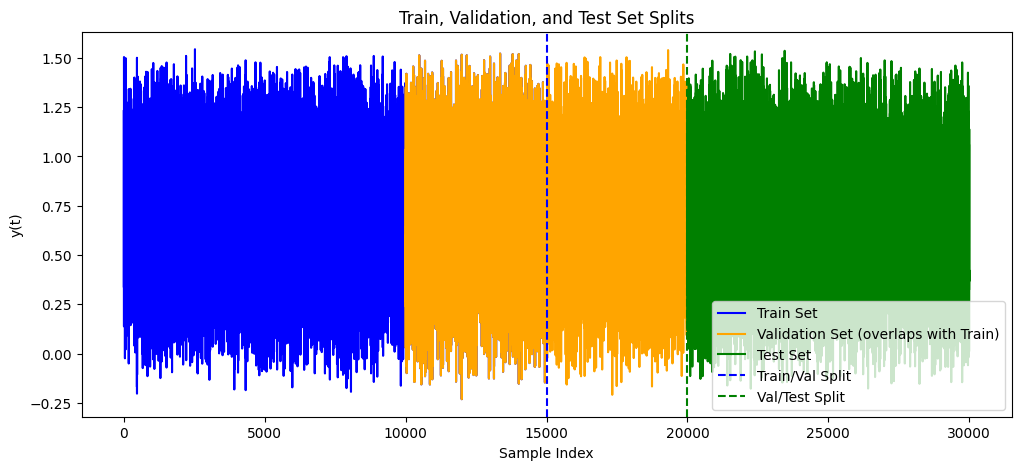

In [9]:
plt.figure(figsize=(12, 5))

# Define index ranges
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = (test_start + len(Y_test))

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), Y_train, label='Train Set', color='blue')
plt.plot(range(val_start, val_end), Y_val, label='Validation Set (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), Y_test, label='Test Set', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='blue', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='green', linestyle='--', label='Val/Test Split')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.title('Train, Validation, and Test Set Splits')
plt.show()

**(4). NORMALISASI DATASET**

In [10]:
# --- NORMALISASI (-1, 1) ---
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

# Fit training data
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

# Transform validation and testing data
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

# --- CEK HASIL ---
print("Scaled Training  : ", X_train_scaled.shape, Y_train_scaled.shape)
print("Scaled Validation: ", X_val_scaled.shape, Y_val_scaled.shape)
print("Scaled Testing   : ", X_test_scaled.shape, Y_test_scaled.shape)

Scaled Training  :  (15000, 9) (15000, 1)
Scaled Validation:  (10000, 9) (10000, 1)
Scaled Testing   :  (10000, 9) (10000, 1)


**Visualisasi Dataset Normalisasi**

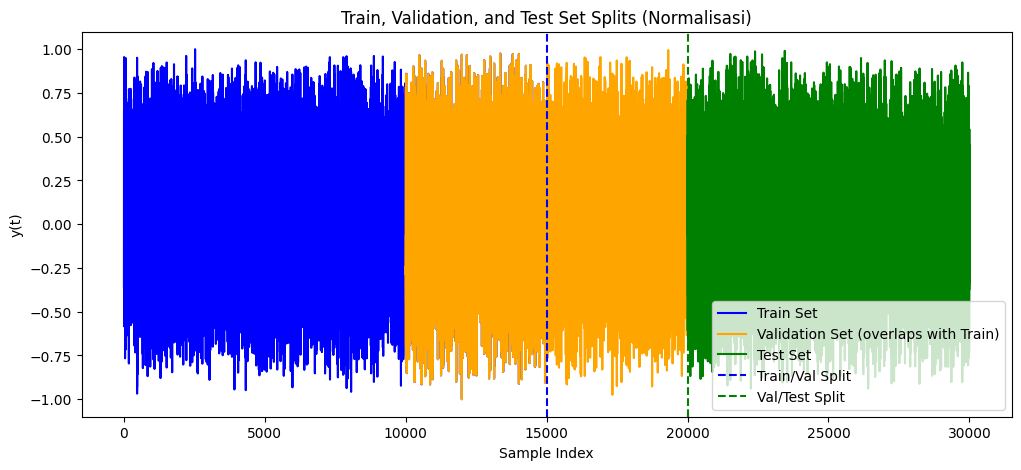

In [11]:
plt.figure(figsize=(12, 5))

# Define index ranges
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = (test_start + len(Y_test_scaled))

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), Y_train_scaled, label='Train Set', color='blue')
plt.plot(range(val_start, val_end), Y_val_scaled, label='Validation Set (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), Y_test_scaled, label='Test Set', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='blue', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='green', linestyle='--', label='Val/Test Split')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.title('Train, Validation, and Test Set Splits (Normalisasi)')
plt.show()

## **SISTEM IDENTIFIKASI (PLANT)**

### **STAGE 1**

**(1). BUAT MODEL MPL**

In [21]:
# MLP Model
def build_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error')

model = build_model
model.summary()

AttributeError: 'function' object has no attribute 'summary'

**(2). TRAINING-VALIDATION MODEL**

In [ ]:
# Path to save best weight
weights_path = "bestModels1.keras"

if os.path.exists(weights_path):
    model.load_weights(weights_path)
    print("Loaded weights from", weights_path)
else:
    print("No existing weights found. Starting fresh training.")

    # Checkpoint to monitor errors
    checkpoint = ModelCheckpoint(
        weights_path,
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, # Save best weight
        mode='min'
    )

# For early stopping
early_stopping_criteria = EarlyStopping(patience=20)

# List for callbacks
callbacks_list = [checkpoint, early_stopping_criteria]

# Training - validation
history = model.fit(
    X_train, Y_train, 
    epochs = 1000,
    validation_data = (X_val, Y_val),
    callbacks=callbacks_list
)

# Evaluasi setelah training selesai
train_loss = model.evaluate(X_train, Y_train, verbose=0)
val_loss = model.evaluate(X_val, Y_val, verbose=0)
print(f"loss train-val: {train_loss:.4f} - {val_loss:.4f}")

Epoch 1/1000
444/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1084
Epoch 1: val_loss improved from inf to 0.00145, saving model to bestModels1.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1039 - val_loss: 0.0014
Epoch 2/1000
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7555e-04
Epoch 2: val_loss improved from 0.00145 to 0.00061, saving model to bestModels1.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7474e-04 - val_loss: 6.0698e-04
Epoch 3/1000
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8110e-04
Epoch 3: val_loss improved from 0.00061 to 0.00038, saving model to bestModels1.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.7997e-04 - val_loss: 3.8159e-04
Epoch 4/1000
444/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5502e-04
Epoch 4: val_loss did not improve from 0.00038
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5355e-04 - val_loss: 5.4273e-04
Epoch 5/1000
446/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3616e-04
Epoch 5: val_l

**Plot Loss Train vs Val**

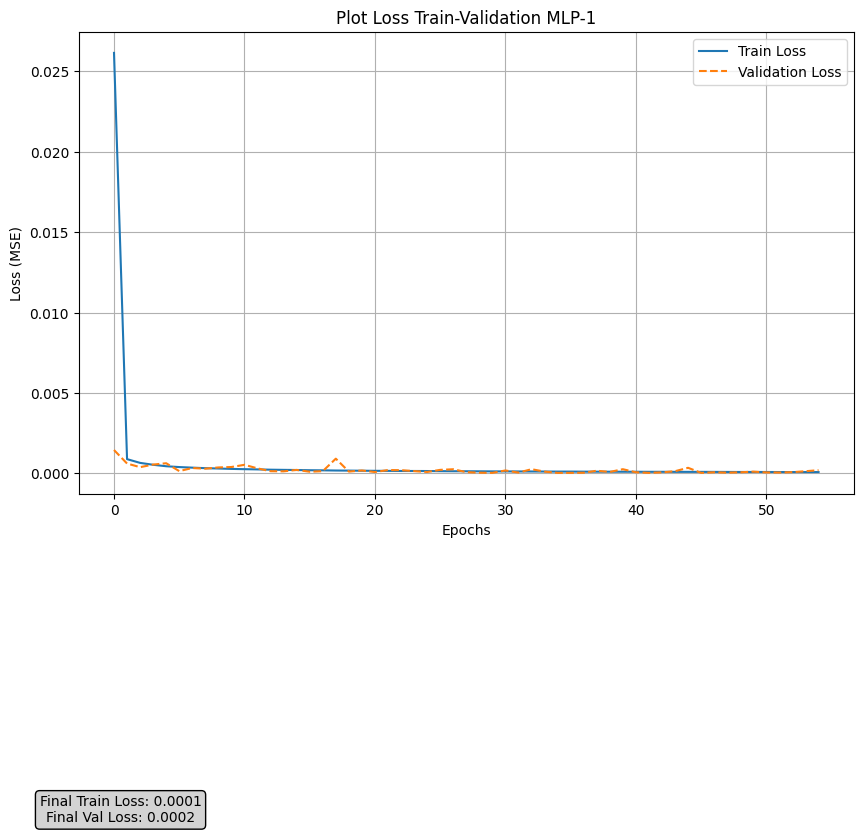

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')

plt.title('Plot Loss Train-Validation MLP-1')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.text(0.5, -0.02, f'Final Train Loss: {history.history["loss"][-1]:.4f}\nFinal Val Loss: {history.history["val_loss"][-1]:.4f}', 
         ha='center', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray"))

plt.show()